# Attention Is All You Need

Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez, Lukasz Kaiser, and Illia Polosukhin.  *NeurIPS 2017*

https://arxiv.org/pdf/1706.03762.pdf 

In [1]:
import os
import re
from typing import Dict
from typing import List
from typing import Tuple

import matplotlib.pyplot as plt
from IPython.display import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

os.chdir(os.path.dirname(os.getcwd()))

## 0 Setup Sample Examples
Following examples are user queries and system responses from a booking-hotel dialogue sample. Our task is to train a model to generate system response given user's request.

In [2]:
sample_queries = [
    "i am looking for a hotel to to stay that has cheap price range.",
    "no, i just need it to be cheap. oh, and i need parking.",
    "yes, please. 6 people 3 nights starting on tuesday.",
    "no, that will be all. good bye."
]
sample_responses = [
    "okay, do you have a specific area you want to stay in?",
    "i found 1 cheap hotel for you that includes parking. do you like me to book it?",
    "booking was successful. anything else i can do for you?",
    "thank you for using our services."
]

### Preprocessing

In [3]:
def PreprocessSentence(sentence: str) -> str:
    """Preprocess an input sentence, make it cosumbale by the model."""
    sentence = sentence.lower().strip()
    # Add whitespace after certain special characters.
    sentence = re.sub(r"([,.?!$%'])", r" \1 ", sentence)
    # Add <start> and <end> token to sentence.
    sentence = "<start> " + sentence + " <end>"
    # Remove the redundant whitespaces.
    sentence = re.sub(r"[' ']+", " ", sentence)

    return sentence

In [4]:
sample_queries = [PreprocessSentence(x) for x in sample_queries]
sample_responses = [PreprocessSentence(x) for x in sample_responses]

print("Sample queries:")
for query in sample_queries: print(query)
print("\nSample responses:")
for response in sample_responses: print(response)

Sample queries:
<start> i am looking for a hotel to to stay that has cheap price range . <end>
<start> no , i just need it to be cheap . oh , and i need parking . <end>
<start> yes , please . 6 people 3 nights starting on tuesday . <end>
<start> no , that will be all . good bye . <end>

Sample responses:
<start> okay , do you have a specific area you want to stay in ? <end>
<start> i found 1 cheap hotel for you that includes parking . do you like me to book it ? <end>
<start> booking was successful . anything else i can do for you ? <end>
<start> thank you for using our services . <end>


### Tokenization

In [5]:
def GetTokenizer(input_sentences: List[str], output_sentences) -> Tokenizer:
    """Create tokenizer."""
    tokenizer = Tokenizer(filters="", oov_token="<OOV>")
    tokenizer.fit_on_texts(input_sentences + output_sentences)
    
    return tokenizer

In [6]:
tokenizer = GetTokenizer(sample_queries, sample_responses)
vocab_size = len(tokenizer.word_index)
input_sequences = tokenizer.texts_to_sequences(sample_queries)
target_sequences = tokenizer.texts_to_sequences(sample_responses)
print(f"Vocab size: {vocab_size}\n")
print(tokenizer.word_index)
print(f"\nInput sequences:")
for seq in input_sequences: print(seq)
print(f"\nTarget sequences:")
for seq in target_sequences: print(seq)

Vocab size: 64

{'<OOV>': 1, '.': 2, '<start>': 3, '<end>': 4, 'you': 5, 'i': 6, 'to': 7, ',': 8, 'for': 9, 'that': 10, 'cheap': 11, 'do': 12, '?': 13, 'a': 14, 'hotel': 15, 'stay': 16, 'no': 17, 'need': 18, 'it': 19, 'be': 20, 'parking': 21, 'am': 22, 'looking': 23, 'has': 24, 'price': 25, 'range': 26, 'just': 27, 'oh': 28, 'and': 29, 'yes': 30, 'please': 31, '6': 32, 'people': 33, '3': 34, 'nights': 35, 'starting': 36, 'on': 37, 'tuesday': 38, 'will': 39, 'all': 40, 'good': 41, 'bye': 42, 'okay': 43, 'have': 44, 'specific': 45, 'area': 46, 'want': 47, 'in': 48, 'found': 49, '1': 50, 'includes': 51, 'like': 52, 'me': 53, 'book': 54, 'booking': 55, 'was': 56, 'successful': 57, 'anything': 58, 'else': 59, 'can': 60, 'thank': 61, 'using': 62, 'our': 63, 'services': 64}

Input sequences:
[3, 6, 22, 23, 9, 14, 15, 7, 7, 16, 10, 24, 11, 25, 26, 2, 4]
[3, 17, 8, 6, 27, 18, 19, 7, 20, 11, 2, 28, 8, 29, 6, 18, 21, 2, 4]
[3, 30, 8, 31, 2, 32, 33, 34, 35, 36, 37, 38, 2, 4]
[3, 17, 8, 10, 39, 20,

### Padding
Pad the sequences by 0 to get same sequence_length.

In [7]:
def Padding(sequences: List[List[int]]) -> List[List[int]]:
    """Pad sequences."""
    padded = tf.keras.preprocessing.sequence.pad_sequences(
        sequences, padding="post")
    
    return padded

In [8]:
input_sequences = Padding(input_sequences)
max_input_len = len(input_sequences[0])
print(f"Padded input sequences:")
for seq in input_sequences: print(seq)
print(f"max_input_len: {max_input_len}")
      
target_sequences = Padding(target_sequences)
max_target_len = len(target_sequences[0])
print(f"\nPadded target sequences:")
for seq in target_sequences: print(seq)
print(f"max_target_len: {max_target_len}")

Padded input sequences:
[ 3  6 22 23  9 14 15  7  7 16 10 24 11 25 26  2  4  0  0]
[ 3 17  8  6 27 18 19  7 20 11  2 28  8 29  6 18 21  2  4]
[ 3 30  8 31  2 32 33 34 35 36 37 38  2  4  0  0  0  0  0]
[ 3 17  8 10 39 20 40  2 41 42  2  4  0  0  0  0  0  0  0]
max_input_len: 19

Padded target sequences:
[ 3 43  8 12  5 44 14 45 46  5 47  7 16 48 13  4  0  0  0  0  0]
[ 3  6 49 50 11 15  9  5 10 51 21  2 12  5 52 53  7 54 19 13  4]
[ 3 55 56 57  2 58 59  6 60 12  9  5 13  4  0  0  0  0  0  0  0]
[ 3 61  5  9 62 63 64  2  4  0  0  0  0  0  0  0  0  0  0  0  0]
max_target_len: 21


### Create tfDataset

In [9]:
BATCH_SIZE = 4
BUFFER_SIZE = 4
dataset = tf.data.Dataset.from_tensor_slices((input_sequences, target_sequences))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(next(iter(dataset)))

(<tf.Tensor: shape=(4, 19), dtype=int32, numpy=
array([[ 3, 17,  8,  6, 27, 18, 19,  7, 20, 11,  2, 28,  8, 29,  6, 18,
        21,  2,  4],
       [ 3,  6, 22, 23,  9, 14, 15,  7,  7, 16, 10, 24, 11, 25, 26,  2,
         4,  0,  0],
       [ 3, 30,  8, 31,  2, 32, 33, 34, 35, 36, 37, 38,  2,  4,  0,  0,
         0,  0,  0],
       [ 3, 17,  8, 10, 39, 20, 40,  2, 41, 42,  2,  4,  0,  0,  0,  0,
         0,  0,  0]], dtype=int32)>, <tf.Tensor: shape=(4, 21), dtype=int32, numpy=
array([[ 3,  6, 49, 50, 11, 15,  9,  5, 10, 51, 21,  2, 12,  5, 52, 53,
         7, 54, 19, 13,  4],
       [ 3, 43,  8, 12,  5, 44, 14, 45, 46,  5, 47,  7, 16, 48, 13,  4,
         0,  0,  0,  0,  0],
       [ 3, 55, 56, 57,  2, 58, 59,  6, 60, 12,  9,  5, 13,  4,  0,  0,
         0,  0,  0,  0,  0],
       [ 3, 61,  5,  9, 62, 63, 64,  2,  4,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0]], dtype=int32)>)


## Abstract
The paper proposes a new simple network architecture, the **Transformer**, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely.

## 1 Introduction & Background

Sequential models including:
 - **(LSTM)** [Long short-term memory](https://www.bioinf.jku.at/publications/older/2604.pdf) Jürgen Schmidhuber, *Neural computation 1997* 
 - **(GRU)** [Empirical evaluation
of gated recurrent neural networks on sequence modeling](https://arxiv.org/pdf/1412.3555.pdf) Kyunghyun Cho, Yoshua Bengio, *CoRR 2014*
 
have established state of art performance in sequence modeling tasks like language modeling and machine translation
 - [Sequence to sequence learning with neural networks](https://arxiv.org/pdf/1409.3215.pdf) Ilya Sutskever, Oriol Vinyals, and Quoc V.Le *NIPS 2014* **(Seq2Seq)**
 - [Neural machine translation by jointly learning to align and translate](https://arxiv.org/abs/1409.0473) Dzmitry **(Bahdanau)**, Kyunghyun Cho, and Yoshua Bengio *CoRR 2014*
 - [ Learning phrase representations using rnn encoder-decoder for statistical machine translation](https://arxiv.org/pdf/1406.1078.pdf) Kyunghyun Cho, Yoshua Bengio *CoRR 2014* **(Enc-Dec)**
 - [Google’s neural machine translation system: Bridging the gap between human and machine translation](https://arxiv.org/pdf/1609.08144.pdf) Quoc V.Le *2016*
 - [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/pdf/1508.04025.pdf) Minh-Thang **(Luong)**, Chris Manning *EMNLP 2015*
 - [Exploring the limits of language modeling](https://arxiv.org/pdf/1602.02410.pdf) Oriol Vinyals *2016*
 
These models **couldn't be parallized** during training due the dependency of previous time step. Recent works improves computational efficiency:
 - [Factorization tricks for LSTM networks](https://arxiv.org/pdf/1703.10722.pdf) Oleksii Kuchaiev and Boris Ginsburg *ICLR 2017* **(Factorization tricks)**
 - [Outrageously large neural networks: The sparsely-gated mixture-of-experts layer](https://arxiv.org/pdf/1701.06538.pdf)  Quoc Le, Geoffrey Hinton, Jeff Dean *2017* **(Conditional computation)**
 
**Attention mechanisms** are mostly used with **recurrent** networks. However in these models, the **number of operations** required and **information loss** grows as the distance between positions increaces.

**Self-attention**, is an attention mechanism relating different positions of a single sequence. It has been used successfully in a variety of tasks including reading comprehension, abstractive summarization, textual entailment and learning task-independent sentence representations.
 - [Long Short-Term Memory-Networks for Machine Reading](https://arxiv.org/pdf/1601.06733.pdf) Jianpeng Cheng, Li Dong, Mirella Lapata *EMNLP 2016*
 - [A structured self-attentive sentence embedding](https://arxiv.org/pdf/1703.03130.pdf) Yoshua Bengio *ICLR 2017*
 - [A decomposable attention model](https://arxiv.org/pdf/1606.01933.pdf) Dipanjan Das, Jakob Uszkoreit *EMNLP 2016*

**Transformer** is the first transduction model relying entirely on **self-attention** without using recurrent networks.



## 2 Model Architecture

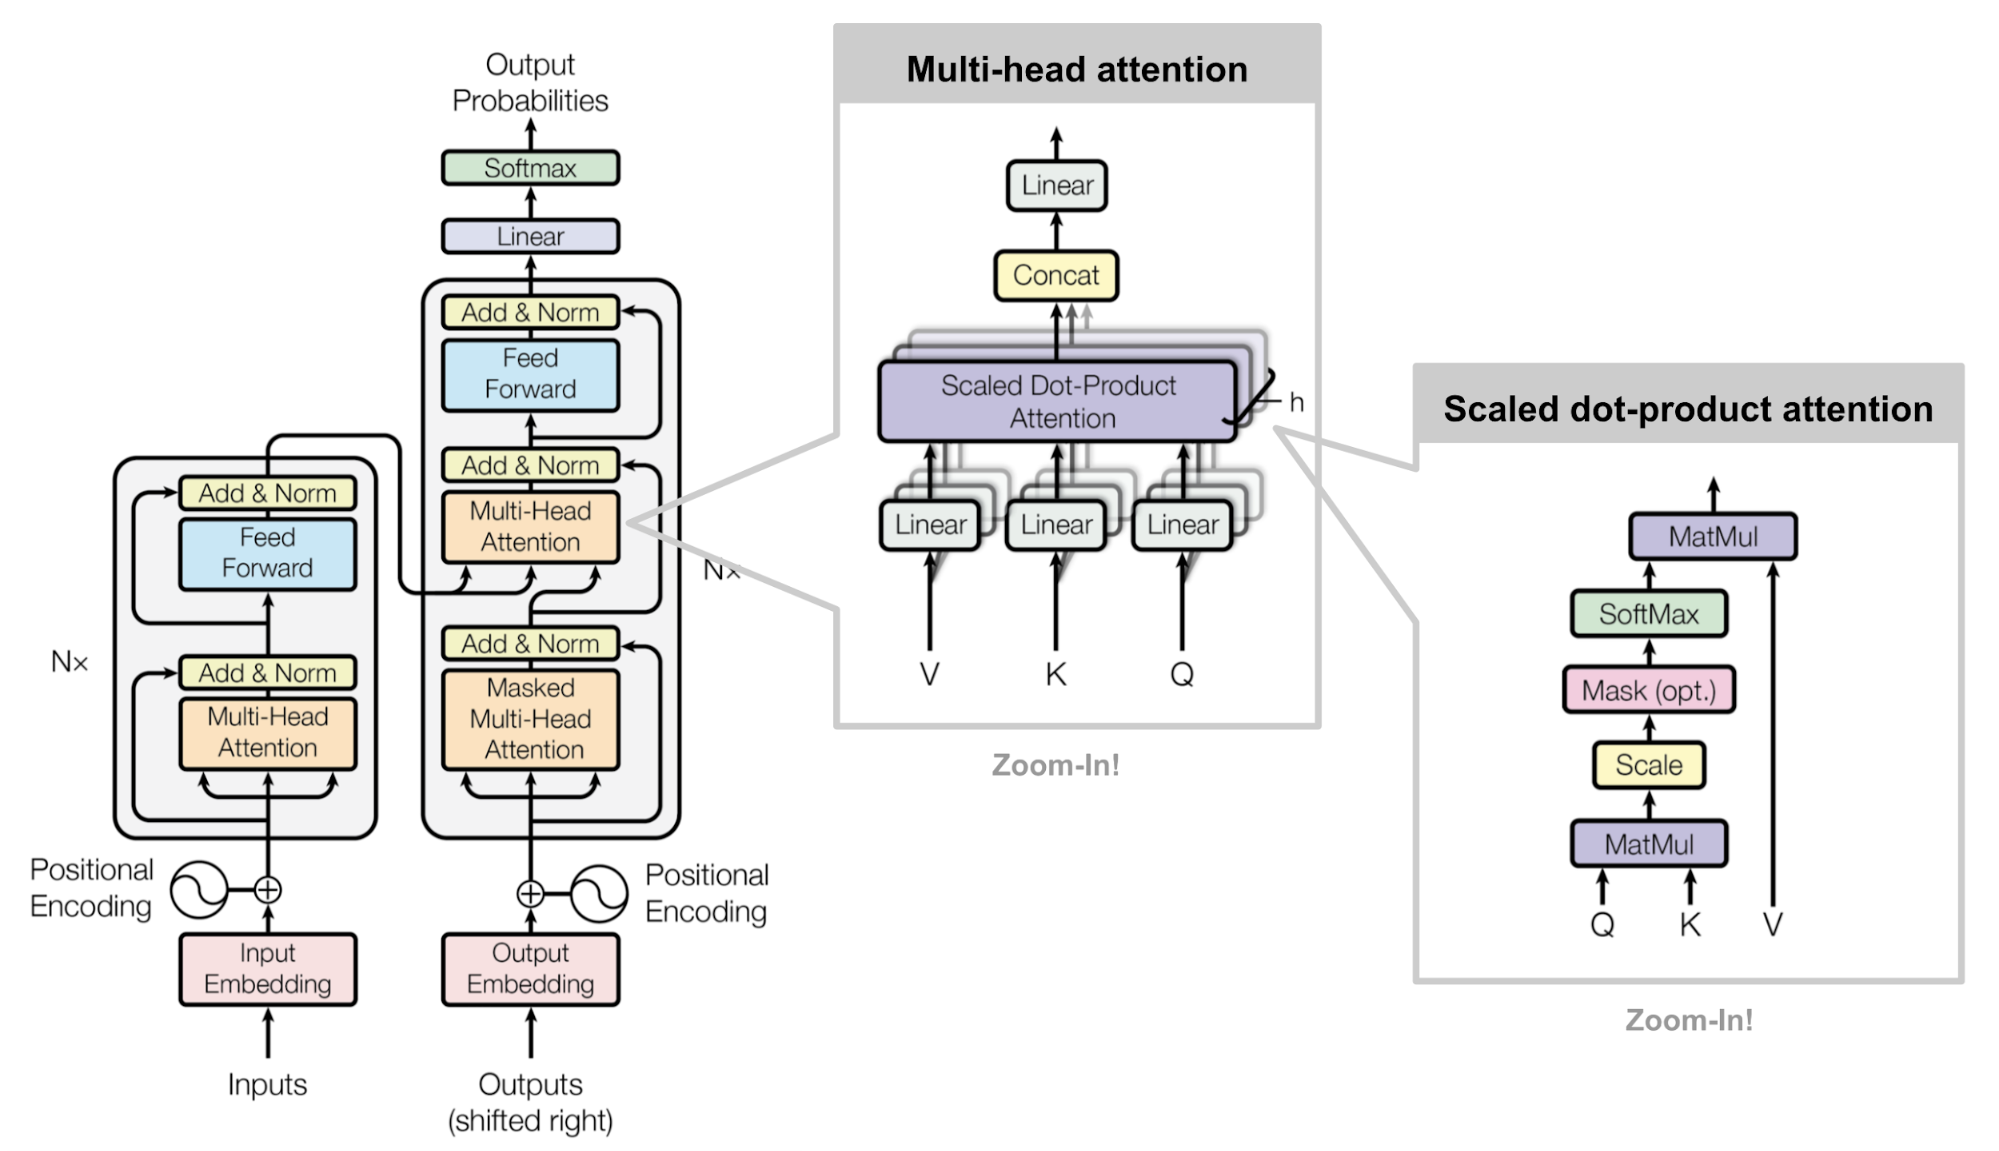

In [10]:
Image(filename='notebooks/figures/transformer_model.png')

### 2.1 Embedding & Softmax

Paper uses learned embeddings, with embedding_size set to $d_{model}$ Token embeddings are scaled by a factor $\sqrt{d_{model}}$ 

Also a learned linear transformation and softmax function is used to convert the decoder output to predicted next-token probabilities. 

In the paper, the same weight matrix is shared between the encoder/decoder embeddings and the pre-softmax linear transformation.

In the paper `d_model=512`

In [11]:
# Example
D_MODEL = 512
input_tensor = next(iter(dataset))[0]
target_tensor = next(iter(dataset))[1]
print(f"Input size: {input_tensor.shape} - (batch_size, max_input_len)")
print(f"Target size: {target_tensor.shape} - (batch_size, max_target_len)")

embbeding_layer = tf.keras.layers.Embedding(
    input_dim=vocab_size+1, # +1 for padding_id==0
    output_dim=D_MODEL)
input_embeddings = embbeding_layer(input_tensor)
target_embeddings = embbeding_layer(target_tensor)

print(f"Input embedding size: {input_embeddings.shape}"
      " - (batch_size, max_input_len, d_model)")
print(f"Target embedding size: {target_embeddings.shape}"
      " - (batch_size, max_target_len, d_model)")

Input size: (4, 19) - (batch_size, max_input_len)
Target size: (4, 21) - (batch_size, max_target_len)
Input embedding size: (4, 19, 512) - (batch_size, max_input_len, d_model)
Target embedding size: (4, 21, 512) - (batch_size, max_target_len, d_model)


### 2.2 Positional Encoding
The model contains no recurrence. In order to make use of the order of the sequence, the paper proposes positional encoding. 

The positional encodings have the same dimension $d_{model}$ as the embeddings so that two can be summed.

Positional encoding could either be learned or fixed (used in this paper)

$$PE_{(pos,2i)}=sin(pos/10000^{2i/d_{model}})$$

$$PE_{(pos,2i+1)}=cos(pos/10000^{2i/d_{model}})$$

In [12]:
class PositionalEncoding(tf.keras.layers.Layer):
    """Get positional encoding.
    Args:
        d_model: Dimensionality of the layers and pooler layer.
        name: Name of the layer.
    """
    def __init__(self, d_model: int, name: str="positional_encoding"):
        super(PositionalEncoding, self).__init__(name=name)
        self.d_model = d_model
        
        
    def get_angles(self, 
                   position: tf.Tensor, 
                   dimension: tf.Tensor, 
                   d_model: int) -> tf.Tensor:
        angles = 1 / tf.pow(10000.0, (2* (dimension // 2)) / tf.cast(d_model, tf.float32))
        
        return position * angles
    
    
    def positional_encoding(self, 
                            total_length: int, 
                            d_model: int) -> tf.Tensor:
        angles = self.get_angles(
            position=tf.range(total_length, dtype=tf.float32)[:, tf.newaxis],
            dimension=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        mask = tf.tile(tf.constant([1, 0], tf.float32), 
                       tf.constant([d_model//2], tf.int32))
        sines = tf.multiply(mask, tf.math.sin(angles))
        cosines = tf.multiply(tf.reverse(mask, [0]), tf.math.cos(angles))
        pe = sines + cosines
        pe = pe[tf.newaxis, ...]
        
        return tf.cast(pe, tf.float32)
    

    def call(self, sequences: tf.Tensor) -> tf.Tensor:
        positional_encoding = self.positional_encoding(
            tf.shape(sequences)[1], self.d_model)
        return positional_encoding

Shape of (input) positional encoding is (1, 19, 512) - (1, max_input_len, d_model)
Shape of (target) positional encoding is (1, 21, 512) - (1, max_target_len, d_model)


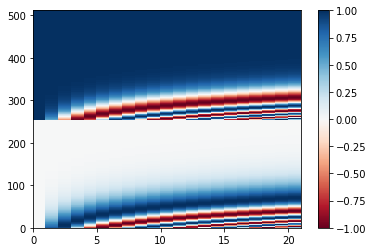

In [13]:
# Example
positional_encoding = PositionalEncoding(D_MODEL)(input_tensor)
print(f"Shape of (input) positional encoding is {positional_encoding.shape}"
      " - (1, max_input_len, d_model)")
input_embeddings +=  positional_encoding
positional_encoding = PositionalEncoding(D_MODEL)(target_tensor)
print(f"Shape of (target) positional encoding is {positional_encoding.shape}"
      " - (1, max_target_len, d_model)")
target_embeddings +=  positional_encoding
    
# Visualization
pe_print = tf.reshape(positional_encoding, (positional_encoding.shape[1], D_MODEL//2, 2))
pe_print = tf.transpose(pe_print, (2,1,0))
pe_print = tf.reshape(pe_print, (D_MODEL, positional_encoding.shape[1]))
plt.pcolormesh(pe_print, cmap="RdBu")
plt.colorbar()
plt.show()

### 2.3 Masking

#### Padding mask
Mask all the pad tokens in the batch of sequences, to make sure the model doesn't treat paddings as inputs.

In [14]:
def GetPaddingMask(sequences: tf.Tensor) -> tf.Tensor:
    """ Create padding mask.
    
    Args:
        sequences: input sequences, of shape (batch_size, seq_len)
    Returns:
        mask: mask tensor of shape (batch_size, 1, 1, seq_len)
    """
    mask = tf.cast(tf.equal(sequences, tf.constant(0)), tf.float32)
    
    return mask[:, tf.newaxis, tf.newaxis, :]

In [15]:
# Example
input_padding_mask = GetPaddingMask(input_tensor)
target_padding_mask = GetPaddingMask(target_tensor)
print("Input padding mask:")
print(input_padding_mask)

Input padding mask:
tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(4, 1, 1, 19), dtype=float32)


#### Look-ahead mask
A **lower triangular matrix** used to mask the future tokens in the batch of sequences so that the model doesn't cheat on training.

In [16]:
def GetLookAheadMask(sequences: tf.Tensor) -> tf.Tensor:
    """ Create look-ahead mask.
    
    Args:
        sequences: input sequences, of shape (batch_size, seq_len)
    Returns:
        mask: mask tensor of shape (seq_len, seq_len)
    """
    seq_len = sequences.get_shape()[1]
    mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    
    return mask

In [17]:
# Example
look_ahead_mask = GetLookAheadMask(target_tensor)
print(look_ahead_mask)

tf.Tensor(
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]

### 2.4 Multi-Head Self-Attention

#### Self-Attention

The self attention function can be described as mapping a **query** and a set of **key-value** pairs (Q, K, V) to an output. Similar to the regular attention mechanism, this is done in three steps:
- **Score** Q (~ decoder hidden in regular attention) and K (~ encoder hidden in regular attention)
- **Aignment** with softmax to get attention weights (same as regular attention)
- **Calculate Attention** as weighted sum of V (~encoder hidden in regular attention)

$$Attention(Q,K,V)=softmax(\frac{QK^T}{\sqrt{d_k}})V$$

Tensor Q, K are of shape (batch_size, seq_len, $d_k$). Tensor V is of shape (batch_size, seq_len, $d_v$)
 - For **encoder** self-attention: Get (Q, K, V) by applying three separate dense layers to input embeddings
 - For **decoder** self-attention: Get (Q, K, V) by applying three separate dense layers to target embeddings
 - For **encoder-decoder** attention: (Q) is the self-attention of decoder, (K, V) are encoder outputs.

The paper chooses **dot-product** attention other than additive attention, which is **much faster** and **more space-efficient** in practice with highly optimized matrix multiplication code.

For large $d_k$, additive over-performs dot-product while for small $d_k$ they are similar. This might due to the fact that for large $d_k$, dot products grow large in magnitude, pushing softmax function into regions where gradients are extremely small. To counteract this affect, the scoring is scaled by $\sqrt{d_k}$

#### Multi-Headed

Instead of performing a single attention function with $d_model$-dimensional Q, K and V, the paper finds it beneficial to split the calculation into many hedas and concatenate them at the end. This improves the performace of attention layer in two ways:

- Expands the models's ability to **focus on different positions**.
- It gives the attention layer multiple **representation subspaces**.

$$MultiHead(Q,K,V)=Concat(head_1, head_2, ... head_h)W^o$$
$$head_i=Attention(QW_i^Q, KW_i^K, VW_i^W)$$

In the paper `num_heads=8`, baseline `d_k=64`, `d_v=64`

In [18]:
class MultiHeadedAttention(tf.keras.layers.Layer):
    """Multi-Headed Attention Layer
    
    Args:
        num_heads: Number of heads to split into.
        d_model: Dimensionality of the layers and pooler layer.
        d_k: Dimensionality of Query and Key tensor.
        d_v: Dimensionality of Value tensor.
        name: Name of the layer.
    """
    def __init__(self, 
                 num_heads: int, 
                 d_model: int,  
                 d_k: int, 
                 d_v: int, 
                 name: str="attention"):
        super(MultiHeadedAttention, self).__init__(name=name)
        self.num_heads = tf.cast(num_heads, tf.int32)
        self.d_model = tf.cast(d_model, tf.int32)
        self.d_k = tf.cast(d_k, tf.int32)
        self.d_v = tf.cast(d_v, tf.int32)

        assert d_k % num_heads == 0, "d_k need to be divisible by num_heads."
        assert d_v % num_heads == 0, "d_v need to be divisible by num_heads."
        
        self.depth_k = d_k // num_heads
        self.depth_v = d_v // num_heads
        
        self.query_linear = tf.keras.layers.Dense(units=d_k)
        self.key_linear = tf.keras.layers.Dense(units=d_k)
        self.value_linear = tf.keras.layers.Dense(units=d_v)
        
        self.output_linear = tf.keras.layers.Dense(units=d_model)
        

    def split_heads(self, 
                    input_tensor: tf.Tensor, 
                    num_heads: int, 
                    depth: int) -> tf.Tensor:
        """Split the original tensor into multi-headed.

        Args:
            input_tensor: The original tensor of shape (batch_size, seq_len, d_model).
            num_heads: Number of heads to split into.
            depth: Dimensionality of at each head.
        Returns:    
            splitted_input: The splitted tensor of shape (batch_size, num_heads, seq_len, depth).
        """
        # shape of (batch_size, seq_len, num_heads, depth)
        splitted_input = tf.reshape(
            input_tensor, 
            (tf.shape(input_tensor)[0], tf.shape(input_tensor)[1], num_heads, depth))
        # shape of (batch_size, num_heads, seq_len, depth)
        splitted_input = tf.transpose(splitted_input, perm=[0, 2, 1, 3])

        return splitted_input

    
    def scaled_dot_product_attention(self,
                                     query: tf.Tensor,
                                     key: tf.Tensor,
                                     value: tf.Tensor,
                                     mask: tf.Tensor) -> tf.Tensor:
        """Calculate self-attention:
            Attention(Q, K, V) = softmax(Qk^T/sqrt(d_k))V

        Args:
            query: The query tensor of shape (batch_size, num_heads, seq_len, depth_q)
            key: The query tensor of shape (batch_size, num_heads, seq_len, depth_k)
            value: The query tensor of shape (batch_size, num_heads, seq_len, depth_v)
            mask: The mask tensor of shape (batch_size, 1, 1, seq_len)
        Returns:
            attention: The self-attention of shape (batch_size, num_heads, seq_len, depth_v)
        """
        # Attention - Score (dot-product attention with scaling factor)
        # dot-product scores, of shape (batch_size, num_heads, seq_len<q>, seq_len<k>)
        qk = tf.matmul(query, key, transpose_b=True)
        # Scale the scores to logits, of shape (batch_size, num_heads, seq_len<q>, seq_len<k>)
        logits = qk / tf.math.sqrt(tf.cast(self.d_k, tf.float32))

        # (optional) Mask out zero paddings. (Large negative inputs to softmax are 
        #  near zero in the output)
        if mask is not None:
            logits += (mask * -1e9)

        # Attention - Alignment
        #  - Softmax on the last axis (seq_len<k>) so that the scores add up to 1.
        attention_weights = tf.nn.softmax(logits, axis=-1)

        # Attention - Calculate context vector
        #  - attention is of shape (batch_size, num_heads, seq_len, depth_v)
        attention = tf.matmul(attention_weights, value)

        return attention, attention_weights
        
        
    def call(self, inputs: Dict[str, tf.Tensor]) -> tf.Tensor:
        """
        Args:
            inputs: A dict of tensor:
                - query: Input tensor for calculating Q.
                - key: Input tensor for calculating K. 
                - value: Input tensor for calculating V. 
                - mask: (optional) Mask tensor.
        """
        query = inputs["query"]
        key = inputs["key"]
        value = inputs["value"]
        mask = inputs["mask"]
        batch_size = tf.shape(query)[0]
        
        # Calculate Q, K, V tensors of shape 
        # (batch_size, seq_len, d_model)
        q = self.query_linear(query)
        k = self.key_linear(key)
        v = self.value_linear(value)
        
        # Split tensors into multi-headed of shape
        # (batch_size, num_heads, seq_len, depth)
        q = self.split_heads(q, self.num_heads, self.depth_k)
        k = self.split_heads(k, self.num_heads, self.depth_k)
        v = self.split_heads(v, self.num_heads, self.depth_v)
        
        # Calcualte the scaled dot-produt attention of shape
        # (batch_size, num_heads, seq_len, depth_v)
        scaled_attention, attention_weights = self.scaled_dot_product_attention(
            query=q, key=k, value=v, mask=mask)
        
        # Reshape the attention to (batch_size, seq_len, num_heads, depth_v)
        scaled_attention = tf.transpose(scaled_attention, perm=[0,2,1,3])
        # Concat the attention on heads, to shape of (batch_size, seq_len, d_v)
        concat_attention = tf.reshape(scaled_attention, [batch_size, -1, self.d_v])
        # Output linear layers of shape (batch_size, seq_len, d_model)
        output = self.output_linear(concat_attention)
        
        return output, attention_weights

In [19]:
# Example
D_K, D_V = 64, 64
NUM_HEADS = 8
mha_layer = MultiHeadedAttention(NUM_HEADS, D_MODEL, D_K, D_V)
mha, attention_weights = mha_layer({"query":input_embeddings, 
                                    "key": input_embeddings, 
                                    "value": input_embeddings, 
                                    "mask": input_padding_mask})
print(f"Attention: {mha.shape} - (batch_size, max_input_len, d_model)")
print(f"Attention weights: {attention_weights.shape}"
      " - (batch_size, num_heads, max_input_len, max_input_len)")

Attention: (4, 19, 512) - (batch_size, max_input_len, d_model)
Attention weights: (4, 8, 19, 19) - (batch_size, num_heads, max_input_len, max_input_len)


### 2.5 Position-wise Feed-forward Networks
Position wise feed forward network is applied after the attention layer. This consists of two fully-connected layers with a ReLU activation in between.

$$FFN(x)=\max(0,xW_1+b_1)W_2+b_2$$

Dimension of first layer is $d_{ff}$, and of second layer is $d_{model}$

In the paper, `d_ff=2048`

In [20]:
class PositionWiseFeedForwardLayer(tf.keras.layers.Layer):
    """ Position-wise feed forward layer.
    Args:
        d_ff: Dimensionality of the feed-forward layer.
        d_model: Dimensionality of the layers and pooler layer.
        name: Name of the layer.
    """
    def __init__(self, d_ff: int, d_model: int, name: str="feed_forward"):
        super(PositionWiseFeedForwardLayer, self).__init__(name=name)
        dense1 = tf.keras.layers.Dense(d_ff, activation="relu")
        dense2 = tf.keras.layers.Dense(d_model)
        self.ffn = tf.keras.Sequential([dense1, dense2])
        
    def call(self, sequences: tf.Tensor) -> tf.Tensor:
        """ Position-wise feed forward layer.
        Args:
            sequences: input sequences, of shape (batch_size, seq_len, d_model)
        Returns:
            Tensor of shape (batch_size, seq_len, d_model)
        """
        return self.ffn(sequences)

In [21]:
# Example
D_FF = 2048
ffn = PositionWiseFeedForwardLayer(D_FF, D_MODEL)(mha)
print(f"Feed-forwad layer: {ffn.shape} - (batch_size, max_input_len, d_model)")

Feed-forwad layer: (4, 19, 512) - (batch_size, max_input_len, d_model)


### 2.6 Dropout
A [Dropout layer](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) is applied after each dense layer regularization purpose. In the paper `dropout_rate=0.1`

In [22]:
# Example
DROPOUT_RATE = 0.1
ffn = tf.keras.layers.Dropout(DROPOUT_RATE)(ffn, training=True)
zero_rate = tf.reduce_mean(tf.cast(tf.equal(ffn, 0.0), tf.float32))
print(f"Zero neurons: {zero_rate.numpy()*100}%")

Zero neurons: 9.98663678765297%


### 2.7 Layer Normalizaton

[Layer Normalization](https://arxiv.org/pdf/1607.06450.pdf) is applied to reduce the **internal covariate shift**.

For each example $x_b$ in the mini-batch, over each token $i$ and it's $k$ dimensional features

$$\hat{x}_{bik} = \frac{x_{bik}-\mu_{bi}}{\sqrt{\sigma_{bi}^2+\epsilon}}$$

$$LN_{\gamma,\beta}(x_{bi})=\gamma\hat{x}_{bi}+\beta$$

By default $\gamma=1$ and $\beta=0$

Compared to [Batch Normalization](https://arxiv.org/pdf/1502.03167.pdf), Layer Normalization is not affected by the bias of mini-batch distribution, so could be applied to small mini-batches. Also there is no need to cache the mean and variance of each mini-batch, which is space efficient.

In [23]:
# Example
layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)(ffn)
print(f"Layer Norm: {layernorm.shape} - (batch_size, max_input_len, d_model)")

Layer Norm: (4, 19, 512) - (batch_size, max_input_len, d_model)


### 2.7 Encoder
The encoder is composed of a stack of `N=6` identical layers. Each layer has two sub-layers:
 - Multi-head self-attention $\rightarrow$ Dropout $\rightarrow$ Add & LayerNorm
 - Feed forward $\rightarrow$ Dropout $\rightarrow$ Add & LayerNorm

In [24]:
def EncoderLayer(num_heads: int, 
                 d_model: int, 
                 d_ff: int, 
                 d_k: int, 
                 d_v: int, 
                 dropout_rate: float, 
                 is_training: bool=True, 
                 name: str="encoder_layer"):
    """Transformer encoder.

    Inputs:
        sequences: Indices of input sequence tokens, of shape 
            (batch_size, max_input_len, d_model)
        padding_mask: Mask to avoid performing attention on padding token indices,
            of shape (batch_size, 1, 1, max_input_len)
    Args:
        num_heads: Number of heads for the multi-head attention.
        d_model: Dimensionality of the layers and pooler layer.
        d_ff: Dimensionality of the feed-forward layer.
        d_k: Dimensionality of Query and Key tensor.
        d_v: Dimensionality of Value tensor.
        dropout_rate: The dropout rate for all fully-connected layers.
        is_training: Boolean value indicating whether is in training mode (add dropout)
            or inference mode (do nothing).
        name: Name of the layer.
    Returns:
        Tensor of shape (batch_size, max_input_len, d_model)
    """
    sequences = tf.keras.Input(shape=(None, d_model), name="sequences")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    attention_layer = MultiHeadedAttention(
        num_heads=num_heads, 
        d_model=d_model, 
        d_k=d_k, 
        d_v=d_v, 
        name=name+"_self_attention")
    dropout_layer1 = tf.keras.layers.Dropout(dropout_rate)
    layernorm_layer1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    ff_layer = PositionWiseFeedForwardLayer(
        d_ff=d_ff, d_model=d_model, name=name+"_ffn")
    dropout_layer2 = tf.keras.layers.Dropout(dropout_rate)
    layernorm_layer2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    # Multi-head self-attention layer.
    # - Multi-head self-attention
    attention, _ = attention_layer({"query": sequences, 
                                    "key": sequences, 
                                    "value": sequences, 
                                    "mask": padding_mask})
    # - Dropout
    attention = dropout_layer1(attention, training=is_training)
    # - Add & Layer Norm        
    outputs1 = layernorm_layer1(tf.keras.layers.add([attention, sequences]))
    # Feed-forward sub-layer
    # - Feed-forward networks
    ffn = ff_layer(outputs1)
    # - Dropout
    ffn = dropout_layer2(ffn, training=is_training)
    # - Add & Layer Norm
    outputs2 = layernorm_layer2(tf.keras.layers.add([outputs1, ffn]))

    return tf.keras.Model(
      inputs=[sequences, padding_mask], outputs=outputs2, name=name)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


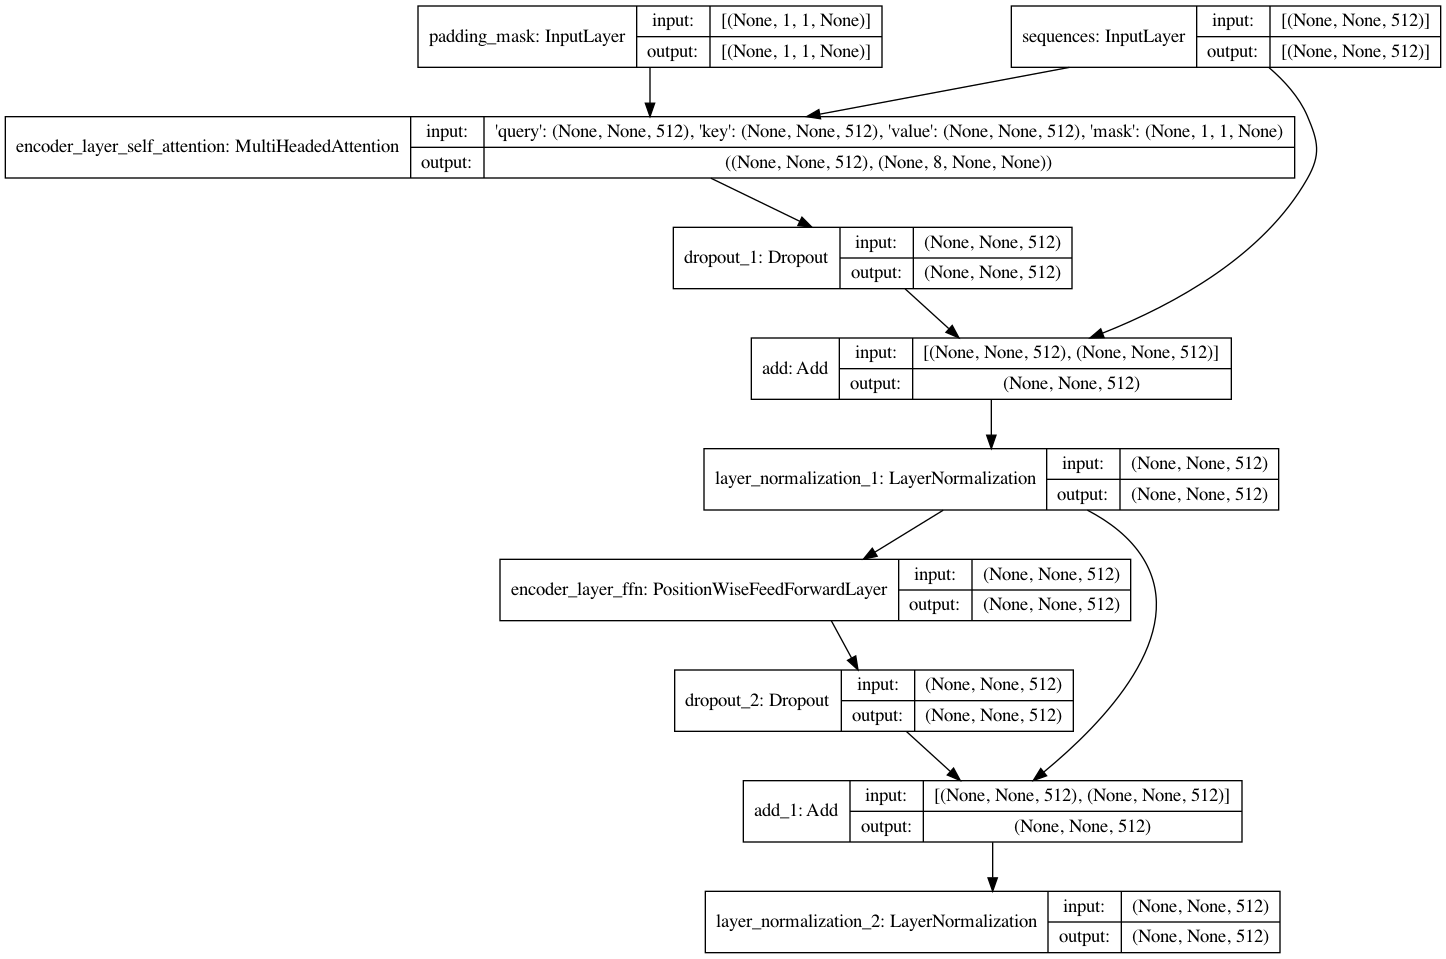

In [25]:
# Example
encoder_layer = EncoderLayer(
    NUM_HEADS, D_MODEL, D_FF, D_K, D_V, DROPOUT_RATE)
tf.keras.utils.plot_model(encoder_layer, show_shapes=True)

In [26]:
def Encoder(num_layers: int, 
            num_heads: int,
            input_vocab_size: int,
            d_model: int, 
            d_ff: int,
            d_k: int, 
            d_v: int, 
            dropout_rate: float,
            is_training: bool=True, 
            name: str="encoder"):
    """Transformer encoder.

    Inputs:
        sequences: Indices of input sequence tokens, of shape 
            (batch_size, max_input_len, d_model)
        padding_mask: Mask to avoid performing attention on padding token indices,
            of shape (batch_size, 1, 1, max_input_len)
    Args:
        num_layers: Number of encoder layers.
        num_heads: Number of heads for the multi-head attention.
        input_vocab_size: Size of input vocab.
        d_model: Dimensionality of the layers and pooler layer.
        d_ff: Dimensionality of the feed-forward layer.
        d_k: Dimensionality of Query and Key tensor.
        d_v: Dimensionality of Value tensor.
        dropout_rate: The dropout rate for all fully-connected layers.
        is_training: Boolean value indicating whether is in training mode (add dropout)
            or inference mode (do nothing).
        name: Name of the Encoder.
    Returns:
        Encoder output, of shape (batch_size, seq_len, d_model)
    """
    sequences = tf.keras.Input(shape=(None, ), name="sequences")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    embedding_layer = tf.keras.layers.Embedding(input_dim=input_vocab_size, 
                                                output_dim=d_model)
    positional_encoding_layer = PositionalEncoding(
        d_model=d_model, name=name+"_positional_encoding")
    dropout_layer = tf.keras.layers.Dropout(dropout_rate)
    encoder_layers = [EncoderLayer(num_heads=num_heads, 
                                   d_model=d_model, 
                                   d_ff=d_ff, 
                                   d_k=d_k, 
                                   d_v=d_v, 
                                   dropout_rate=dropout_rate, 
                                   is_training=is_training, 
                                   name=name+"_layer_"+str(i)) 
                      for i in range(num_layers)]
        
    # Embedding layer
    # - Learned embeddings
    embeddings = embedding_layer(sequences)
    # - Scaling
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    # - Positional encoding
    positional_encoding = positional_encoding_layer(embeddings)
    encodings = tf.keras.layers.add([embeddings, positional_encoding])
    # - Dropout
    encodings = dropout_layer(encodings, training=is_training)

    # Stacked encoder layers
    for encoder_layer in encoder_layers:
        encodings = encoder_layer([encodings, padding_mask])
        
    return tf.keras.Model(
      inputs=[sequences, padding_mask], outputs=encodings, name=name)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


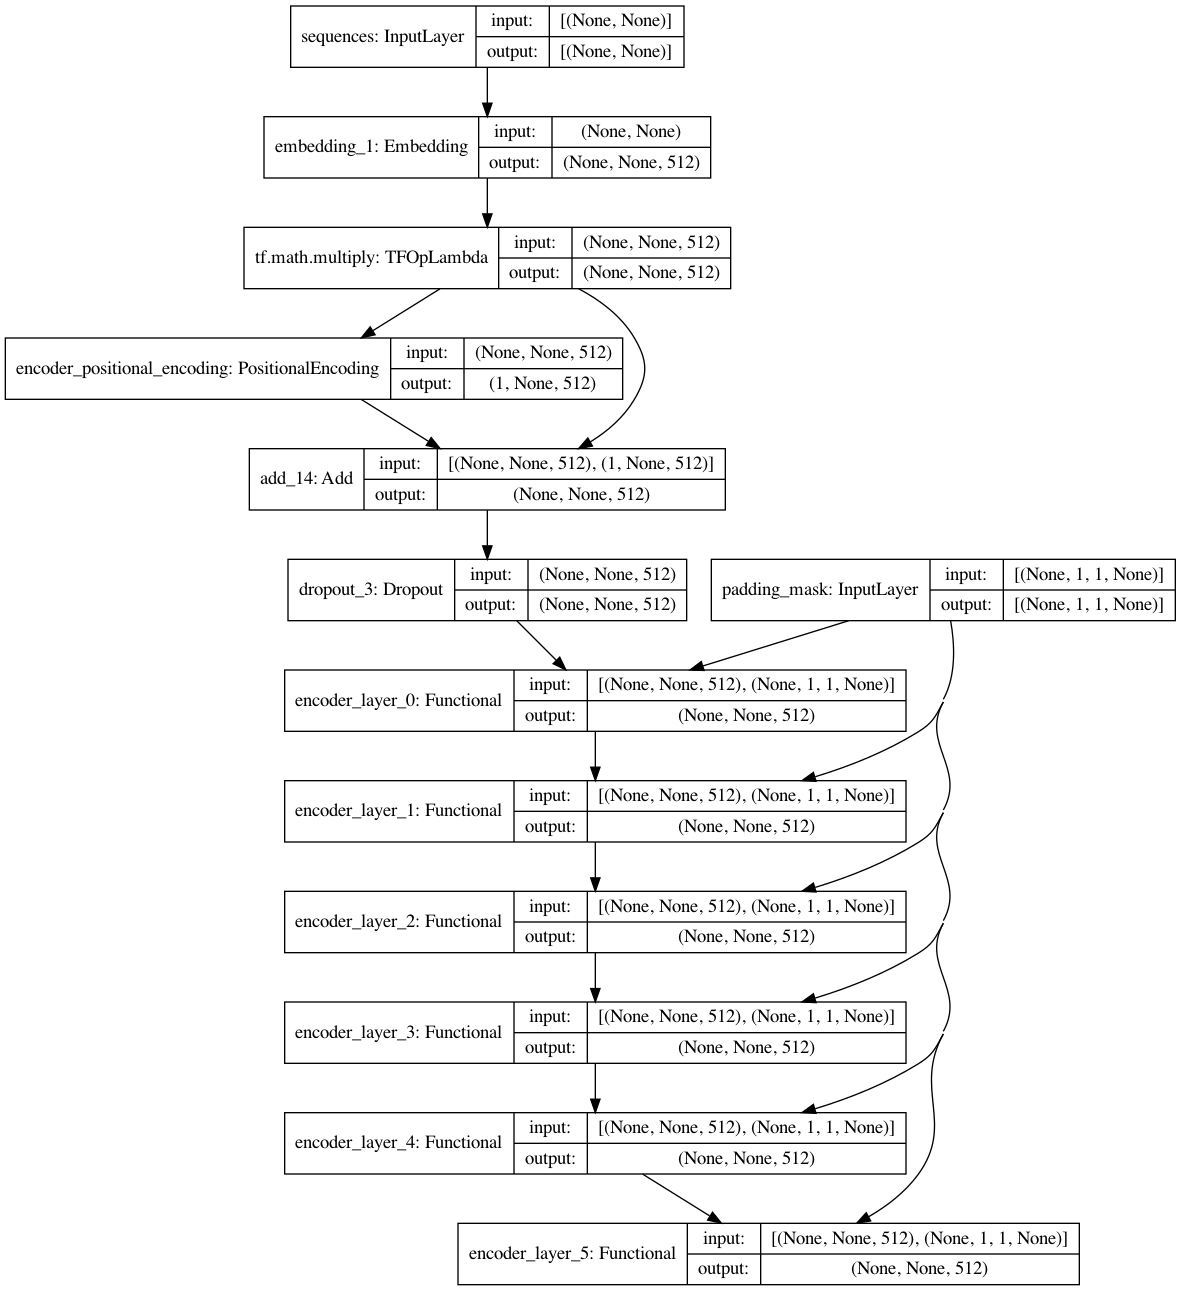

In [27]:
NUM_ENCODER_LAYERS = 6
encoder = Encoder(num_layers=NUM_ENCODER_LAYERS, 
                  num_heads=NUM_HEADS, 
                  input_vocab_size=vocab_size+1, # +1 for padding 
                  d_model=D_MODEL, 
                  d_ff=D_FF,
                  d_k=D_K,
                  d_v=D_V,
                  dropout_rate=DROPOUT_RATE)
tf.keras.utils.plot_model(encoder, show_shapes=True)

### 2.8 Decoder
The decoder is composed of a stack of `N=6` identical layers. Each layer has three sub-layers:
 - Multi-head self-attention $\rightarrow$ Dropout $\rightarrow$ Add & LayerNorm
 - Multi-head encoder-decoder attention $\rightarrow$ Dropout $\rightarrow$ Add & LayerNorm
 - Feed forward $\rightarrow$ Dropout $\rightarrow$ Add & LayerNorm

In [28]:
def DecoderLayer(num_heads: int, 
                 d_model: int, 
                 d_ff: int, 
                 d_k: int, 
                 d_v: int, 
                 dropout_rate: float,
                 is_training: bool=True, 
                 name: str="decoder_layer"):
    """A single transformer decoder layer.
    
    Inputs:
        sequences: Indices of input sequence tokens, of shape 
            (batch_size, max_target_len, d_model)
        encoder_output: of size (batch_size, max_input_len, d_model)
        padding_mask: Mask to avoid performing attention on padding token indices,
            of shape (batch_size, 1, 1, max_target_len)
        look_ahead_mask: Mask to avoid seeing future information.
            of shape (batch_size, 1, max_target_len, max_target_len)    
    Args:
        num_heads: Number of heads for the multi-head attention.
        d_model: Dimensionality of the layers and pooler layer.
        d_ff: Dimensionality of the feed-forward layer.
        d_k: Dimensionality of Query and Key tensor.
        d_v: Dimensionality of Value tensor.
        dropout_rate: The dropout rate for all fully-connected layers.
        is_training: Boolean value indicating whether is in training mode (add dropout)
            or inference mode (do nothing).
        name: Name of the layer.
    Returns:
        Tensor of shape (batch_size, max_target_len, d_model)
    """

    sequences = tf.keras.Input(shape=(None, d_model), name="sequences")
    encoder_output = tf.keras.Input(shape=(None, d_model), name="encoder_output")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")

    self_attention_layer = MultiHeadedAttention(
        num_heads, d_model, d_k, d_v, name=name+"_self_attention")
    dropout_layer1 = tf.keras.layers.Dropout(dropout_rate)
    layernorm_layer1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    enc_dec_attention_layer = MultiHeadedAttention(
        num_heads, d_model, d_k, d_v, name=name+"_enc_dec_attention")
    dropout_layer2 = tf.keras.layers.Dropout(dropout_rate)
    layernorm_layer2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    ff_layer = PositionWiseFeedForwardLayer(d_ff, d_model)
    dropout_layer3 = tf.keras.layers.Dropout(dropout_rate)
    layernorm_layer3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    # Multi-head self-attention layer.
    # - Multi-head self-attention
    self_attention, self_attention_weights = self_attention_layer(
        {"query": sequences, 
         "key": sequences, 
         "value": sequences, 
         "mask": look_ahead_mask})
    # - Dropout        
    self_attention = dropout_layer1(self_attention, training=is_training)
    # - Add & Layer Norm             
    outputs1 = layernorm_layer1(tf.keras.layers.add([sequences, self_attention]))

    # Multi-head encoder-decoder attention layer.
    # - Multi-head encoder-decoder attention        
    enc_dec_attention, enc_dec_attention_weights = enc_dec_attention_layer(
        {"query": self_attention, 
         "key": encoder_output, 
         "value": encoder_output, 
         "mask": padding_mask})
    # - Dropout               
    enc_dec_attention = dropout_layer2(enc_dec_attention, training=is_training)
    # - Add & Layer Norm          
    outputs2 = layernorm_layer2(tf.keras.layers.add([outputs1, enc_dec_attention]))

    # Feed-forward sub-layer
    # - Feed-forward networks
    ffn = ff_layer(outputs2)
    # - Dropout
    ffn = dropout_layer3(ffn, training=is_training)
    # - Add & Layer Norm
    outputs3 = layernorm_layer3(tf.keras.layers.add([outputs2, ffn]))
    
    return tf.keras.Model(
      inputs=[sequences, encoder_output, padding_mask, look_ahead_mask], 
        outputs=outputs3, name=name)

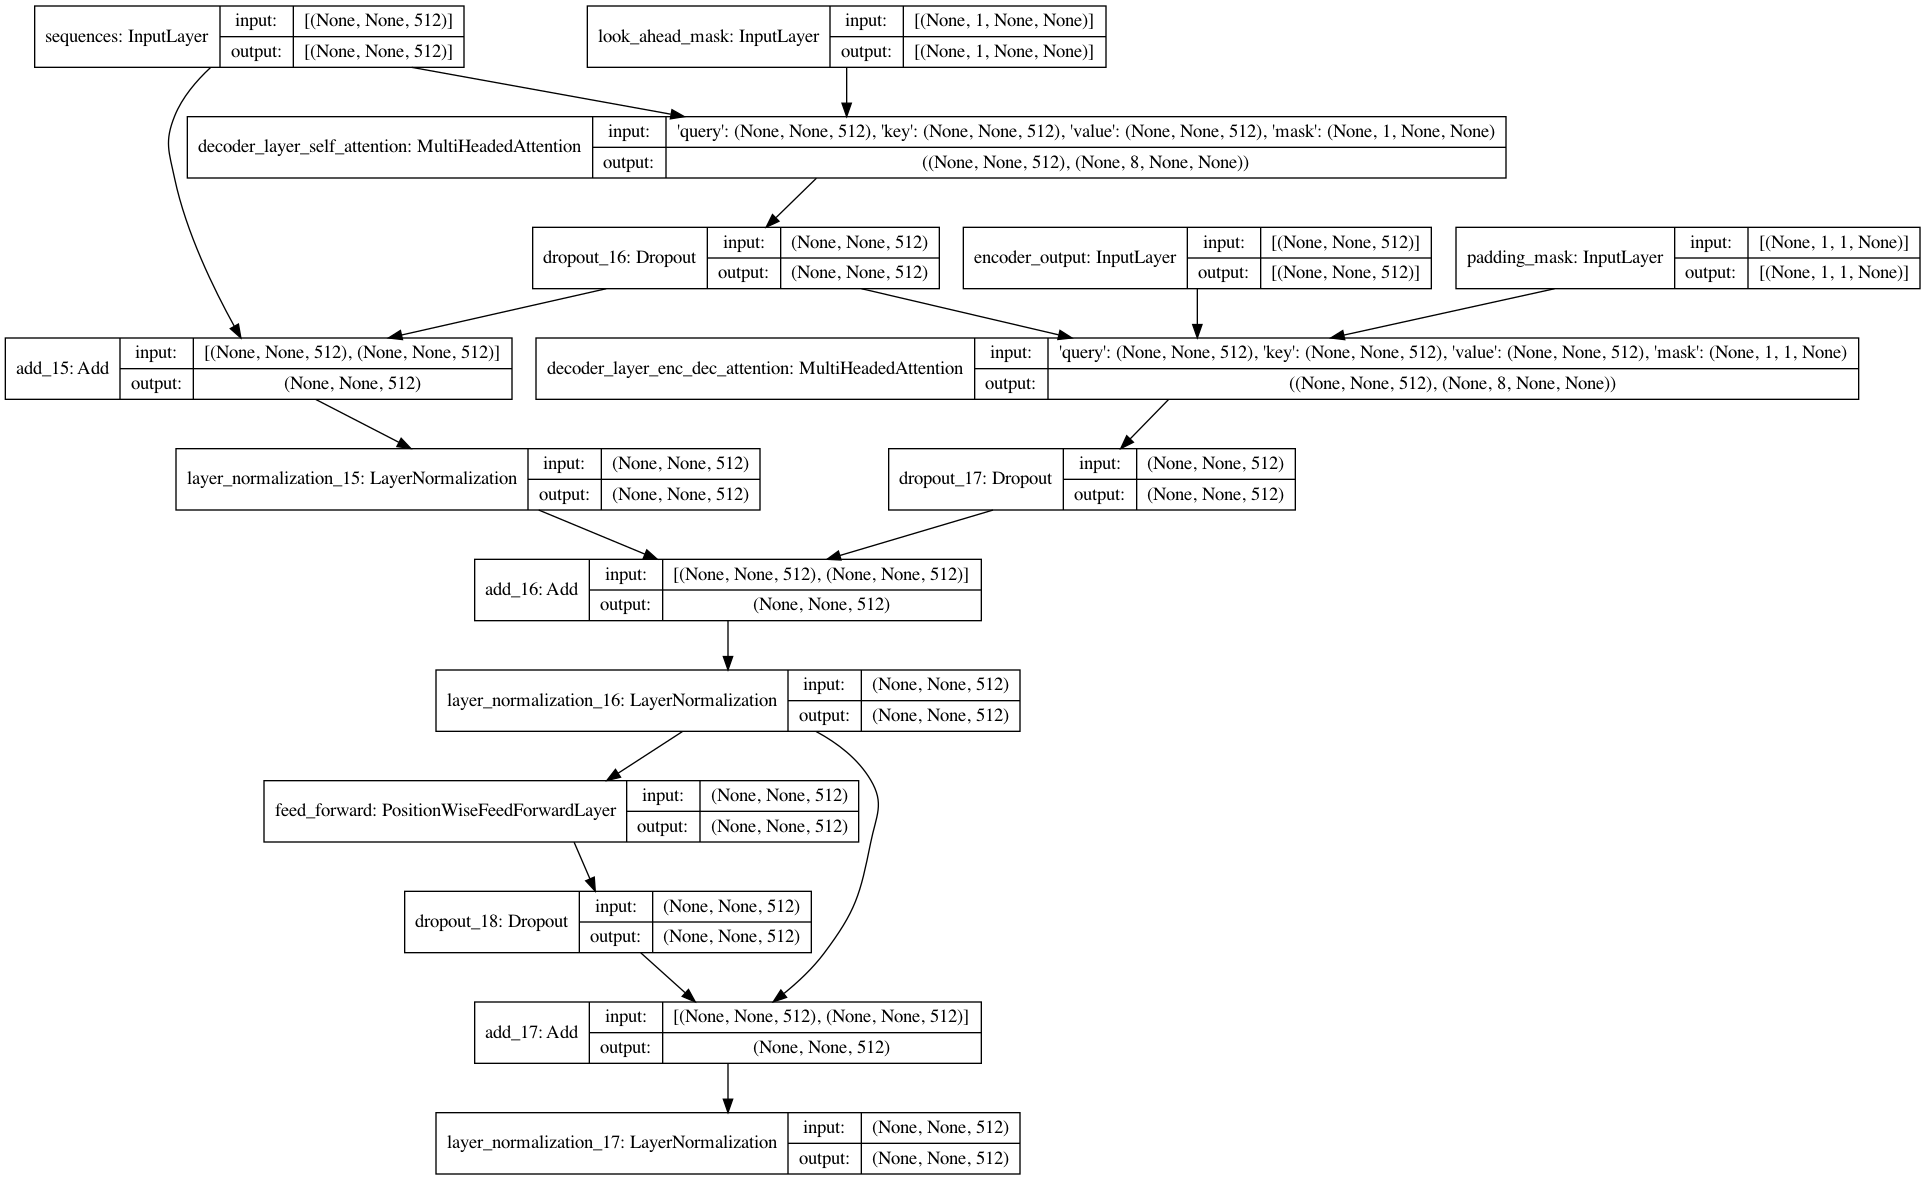

In [29]:
# Example
decoder_layer = DecoderLayer(
    NUM_HEADS, D_MODEL, D_FF, D_K, D_V, DROPOUT_RATE)
tf.keras.utils.plot_model(decoder_layer, show_shapes=True)

In [30]:
def Decoder(num_layers: int, 
            num_heads:int , 
            target_vocab_size: int, 
            d_model: int, 
            d_ff: int, 
            d_k: int, 
            d_v: int, 
            dropout_rate: float, 
            is_training: bool=True,
            name: str="decoder"):
    """Transformer decoder.

    Inputs:
        sequences: Indices of input sequence tokens, of shape 
            (batch_size, max_target_len, d_model)
        encoder_output: of size (batch_size, max_input_len, d_model)
        padding_mask: Mask to avoid performing attention on padding token indices,
            of shape (batch_size, 1, 1,  max_target_len)
        look_ahead_mask: Mask to avoid seeing future information.
            of shape (batch_size, 1,  max_target_len,  max_target_len)    
    Args:
        num_layers: Number of decoder layers.
        num_heads: Number of heads for the multi-head attention.
        target_vocab_size: Size of target vocab.
        d_model: Dimensionality of the layers and pooler layer.
        d_ff: Dimensionality of the feed-forward layer.
        d_k: Dimensionality of Query and Key tensor.
        d_v: Dimensionality of Value tensor.
        dropout_rate: The dropout rate for all fully-connected layers.
        is_training: Boolean value indicating whether is in training mode (add dropout)
            or inference mode (do nothing).
        name: Name of the Decoder.
    Returns:
        Decoder output, of shape (batch_size, max_target_len, d_model)
    """
    sequences = tf.keras.Input(shape=(None, ), name="sequences")
    encoder_output = tf.keras.Input(shape=(None, d_model), name="encoder_output")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    
    embedding_layer = tf.keras.layers.Embedding(input_dim=target_vocab_size, 
                                                output_dim=d_model)
    positional_encoding_layer = PositionalEncoding(d_model, name=name+"_positional_encoding")
    dropout_layer = tf.keras.layers.Dropout(dropout_rate)
    decoder_layers = [DecoderLayer(num_heads=num_heads, 
                                   d_model=d_model, 
                                   d_ff=d_ff, 
                                   d_k=d_k, 
                                   d_v=d_v, 
                                   dropout_rate=dropout_rate, 
                                   is_training=is_training,
                                   name=name+"_layer_"+str(i)) 
                      for i in range(num_layers)]
    
    # Embedding layer
    # - Learned embeddings
    embeddings = embedding_layer(sequences)
    # - Scaling
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    # - Positional encoding        
    positional_encoding = positional_encoding_layer(embeddings)
    encodings = tf.keras.layers.add([embeddings, positional_encoding])
    # - Dropout
    encodings = dropout_layer(encodings, training=is_training)

    # Stacked decoder layers
    for i, decoder_layer in enumerate(decoder_layers):
        encodings = decoder_layer(
            [encodings, encoder_output, padding_mask, look_ahead_mask])
        
    return tf.keras.Model(
      inputs=[sequences, encoder_output, padding_mask, look_ahead_mask], 
        outputs=encodings, name=name)

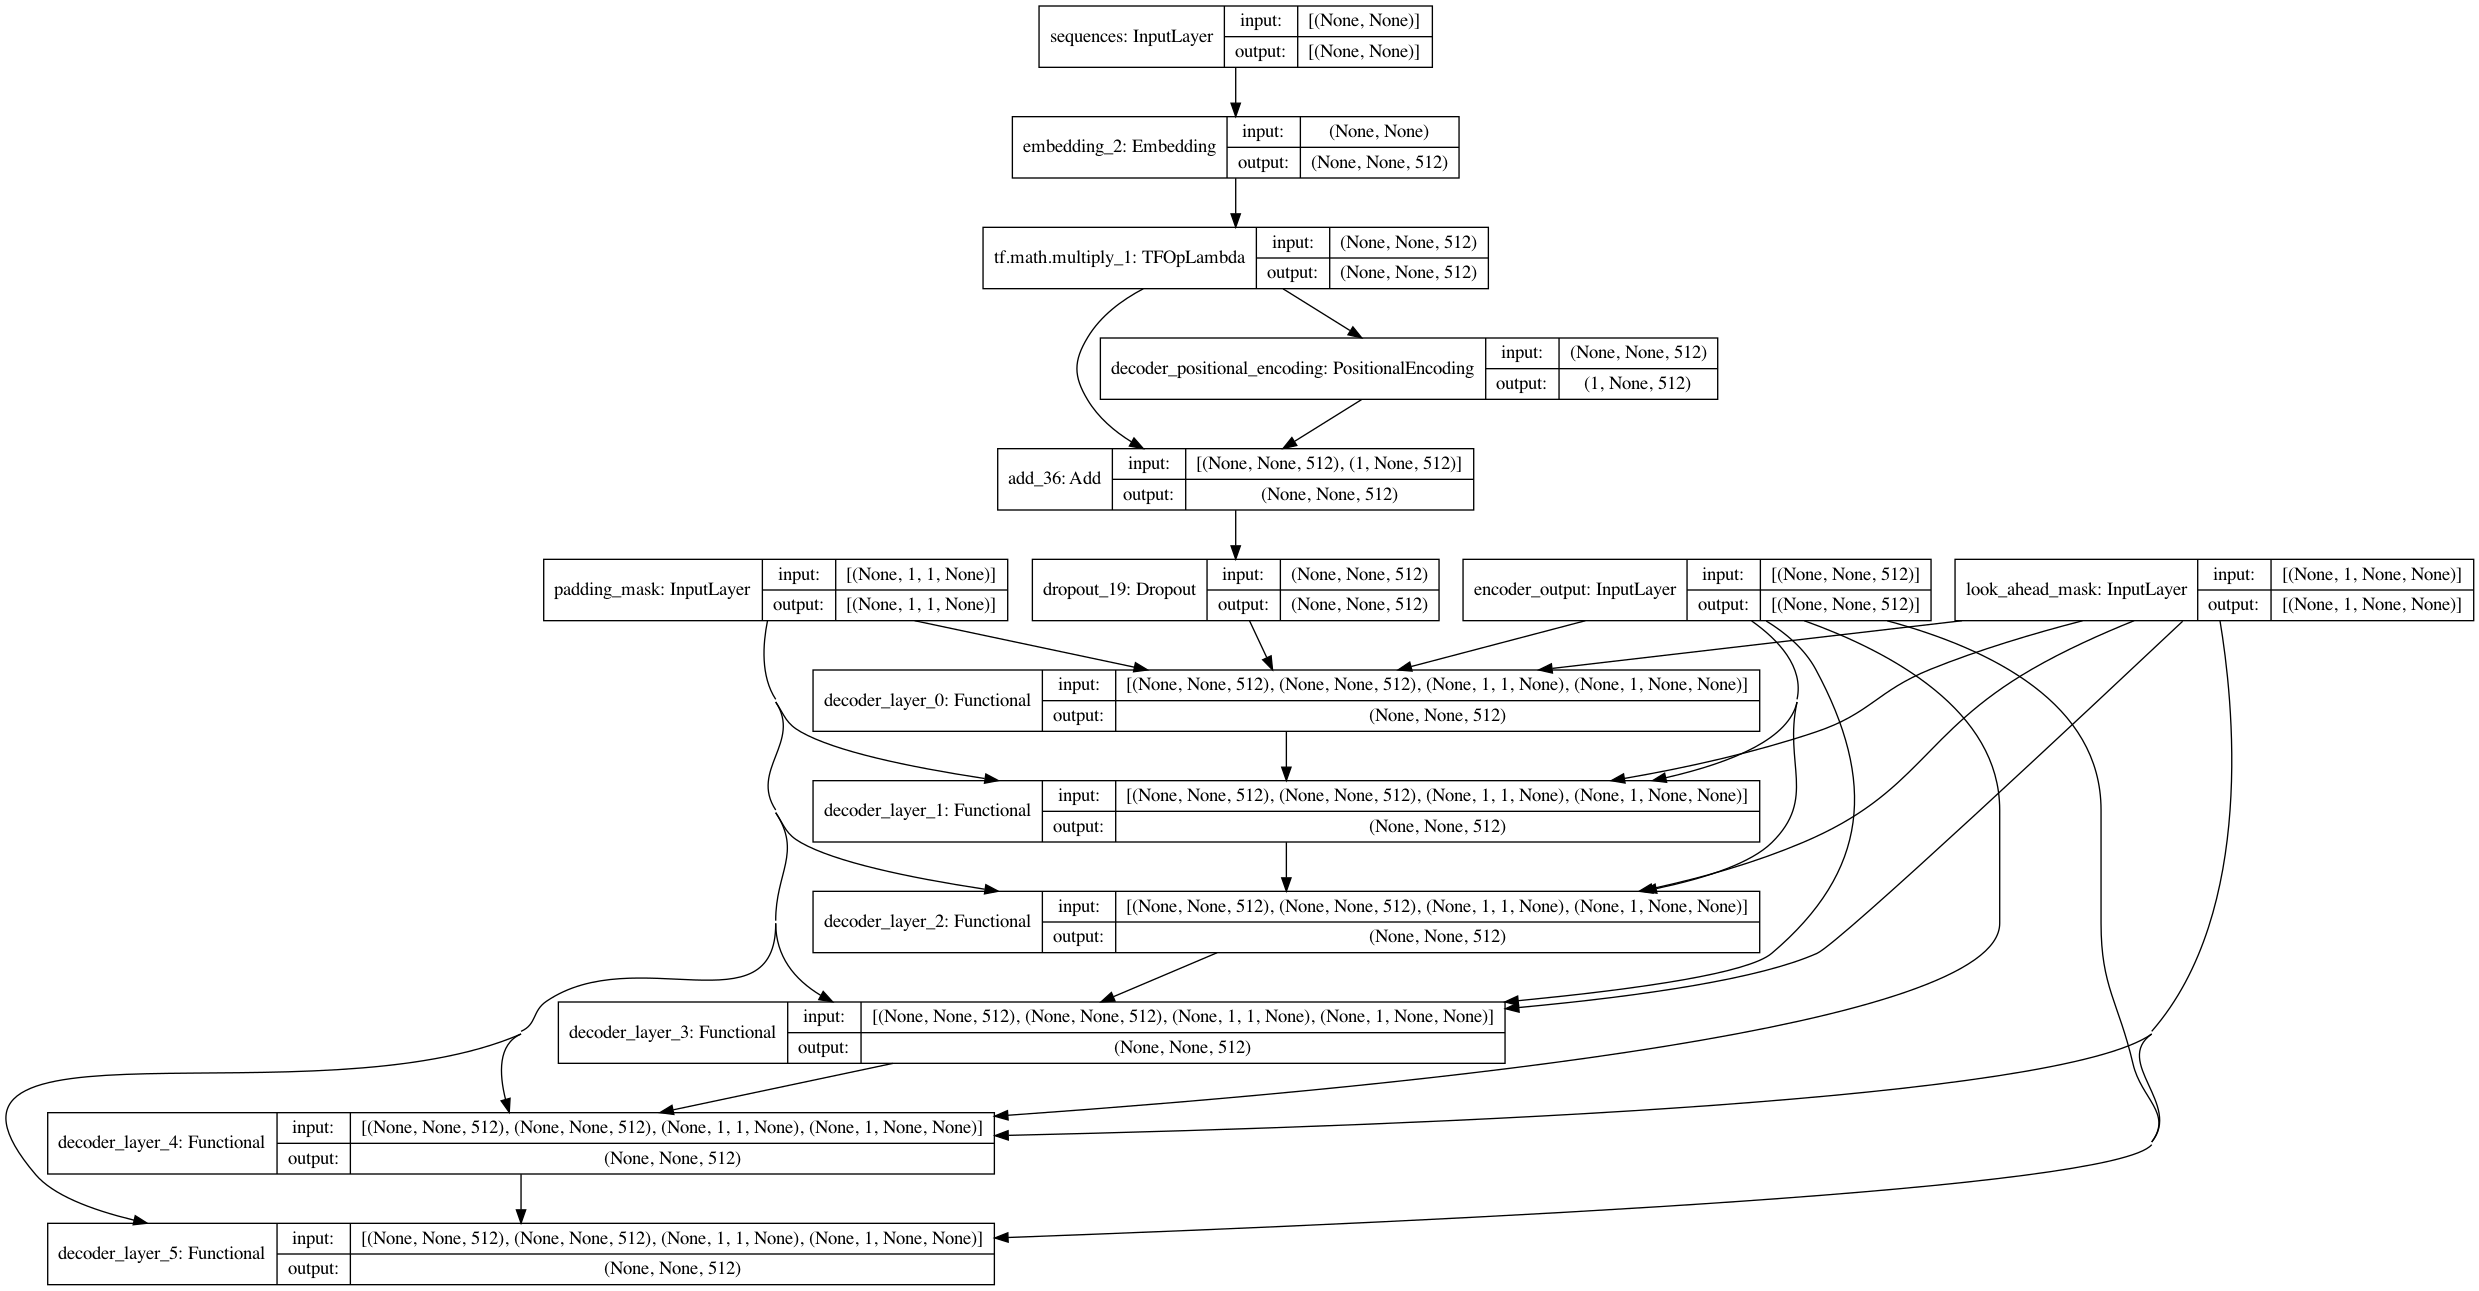

In [31]:
# Example
NUM_DECODER_LAYERS = 6
decoder = Decoder(num_layers=NUM_DECODER_LAYERS, 
                  num_heads=NUM_HEADS, 
                  target_vocab_size=vocab_size+1, # +1 for padding 
                  d_model=D_MODEL, 
                  d_ff=D_FF,
                  d_k=D_K,
                  d_v=D_V,
                  dropout_rate=DROPOUT_RATE)
tf.keras.utils.plot_model(decoder, show_shapes=True)

### 2.8 Transformer

In [32]:
def Transformer(num_encoder_layers: int, 
                num_decoder_layers: int, 
                num_heads: int, 
                input_vocab_size: int, 
                target_vocab_size: int,
                d_model: int, 
                d_ff: int,
                d_k: int,
                d_v: int,
                dropout_rate: int, 
                is_training: bool, 
                name: str="transformer"):
    """Transformer model.
    
    Inputs:
        input_sequences: Indices of input sequence tokens, of shape 
            (batch_size, max_input_len, d_model)
        target_sequences: Indices of target sequence tokens, of shape 
            (batch_size, max_output_len, d_model)
        encoder_output: of size (batch_size, max_input_len, d_model)
        input_padding_mask: Mask to avoid performing attention on padding token indices,
            of shape (batch_size, 1, 1, max_input_len)
        target_padding_mask: Mask to avoid performing attention on padding token indices,
            of shape (batch_size, 1, 1, max_target_len)
        look_ahead_mask: Mask to avoid seeing future information.
            of shape (batch_size, 1, max_target_len, max_target_len)    
        is_training: Boolean value indicating whether is in training mode (add dropout)
            or inference mode (do nothing).
        name: Name of the Transformer.
    Args:
        num_encoder_layers: Number of encoder layers.
        num_decoder_layers: Number of decoder layers.
        num_heads: Number of heads for the multi-head attention.
        input_vocab_size: Size of input vocab.
        target_vocab_size: Size of target vocab.
        d_model: Dimensionality of the layers and pooler layer.
        d_ff: Dimensionality of the feed-forward layer.
        d_k: Dimensionality of Query and Key tensor.
        d_v: Dimensionality of Value tensor.
        dropout_rate: The dropout rate for all fully-connected layers.
    Returns:
        Tensor of shape (batch_size, max_target_len, target_vocab_size)
    """
    input_sequences = tf.keras.Input(shape=(None, ), name="input_sequences")
    target_sequences = tf.keras.Input(shape=(None, ), name="target_sequences")
    input_padding_mask = tf.keras.Input(shape=(1, 1, None), name="input_padding_mask")
    target_padding_mask = tf.keras.Input(shape=(1, 1, None), name="target_padding_mask")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    
    stacked_encoder = Encoder(num_layers=num_encoder_layers, 
                              num_heads=num_heads, 
                              input_vocab_size=input_vocab_size, 
                              d_model=d_model, 
                              d_ff=d_ff, 
                              d_k=d_k, 
                              d_v=d_v, 
                              dropout_rate=dropout_rate, 
                              is_training=is_training, 
                              name="encoder")
    stacked_decoder = Decoder(num_layers=num_decoder_layers, 
                              num_heads=num_heads, 
                              target_vocab_size=target_vocab_size, 
                              d_model=d_model, 
                              d_ff=d_ff, 
                              d_k=d_k, 
                              d_v=d_v, 
                              dropout_rate=dropout_rate, 
                              is_training=is_training, 
                              name="decoder")
    final_linear_layer = tf.keras.layers.Dense(target_vocab_size)
        
    # Encoder - (batch_size, max_input_len, d_model)
    encoder_output = stacked_encoder([input_sequences, input_padding_mask])
    # Decoder - (batch_size, max_target_len, d_model)
    decoder_output = stacked_decoder(
        [target_sequences, encoder_output, target_padding_mask, look_ahead_mask])
    # Linear layer - (batch_size, max_target_len, target_vocab_size)
    final_outputs = final_linear_layer(decoder_output)

    return tf.keras.Model(
      inputs=[input_sequences, 
              target_sequences, 
              input_padding_mask, 
              target_padding_mask, 
              look_ahead_mask], 
        outputs=final_outputs, name=name)

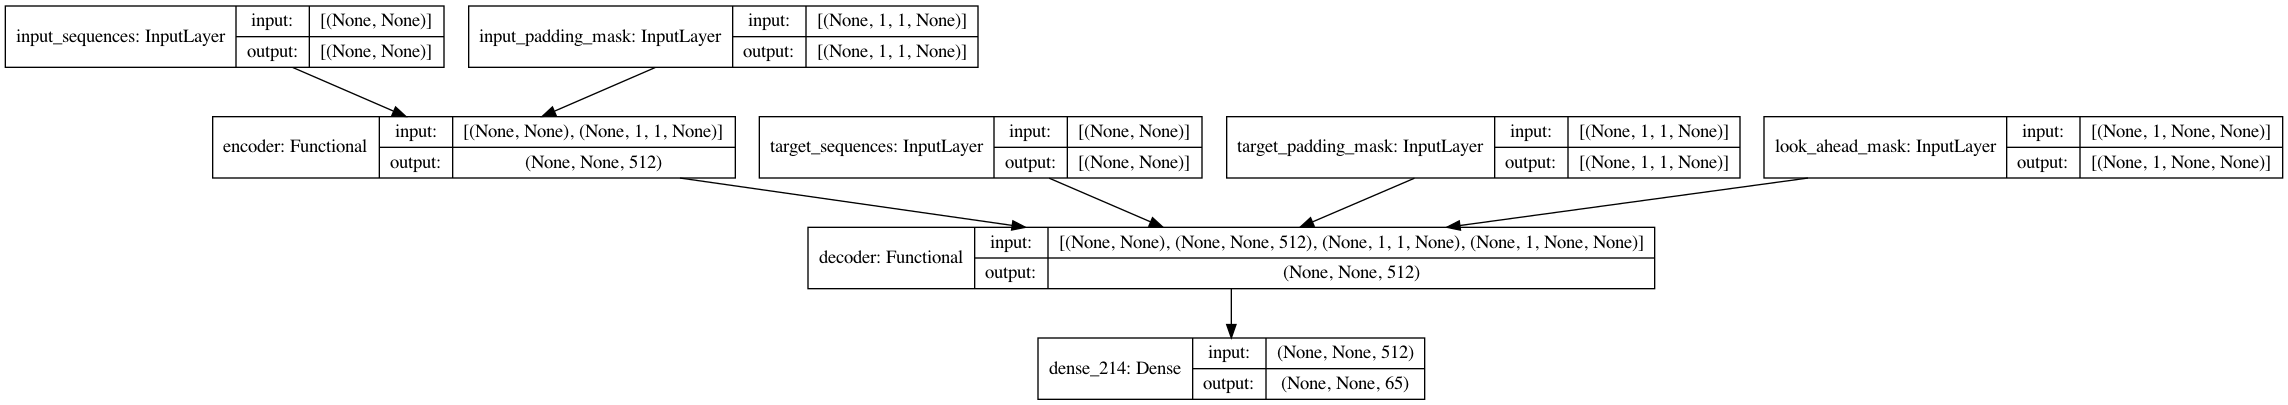

In [33]:
transformer = Transformer(num_encoder_layers=NUM_ENCODER_LAYERS, 
                          num_decoder_layers=NUM_DECODER_LAYERS, 
                          num_heads=NUM_HEADS, 
                          input_vocab_size=vocab_size+1, # +1 for padding
                          target_vocab_size=vocab_size+1, # +1 for padding
                          d_model=D_MODEL, 
                          d_ff=D_FF,
                          d_k=D_K,
                          d_v=D_V,
                          dropout_rate=DROPOUT_RATE, 
                          is_training=True)
tf.keras.utils.plot_model(transformer, show_shapes=True) 